Running 9-layer Galton board...


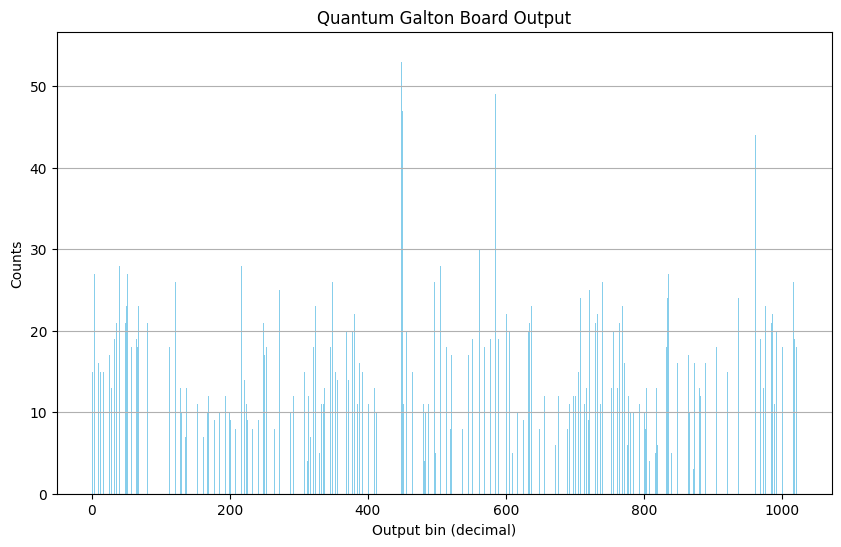

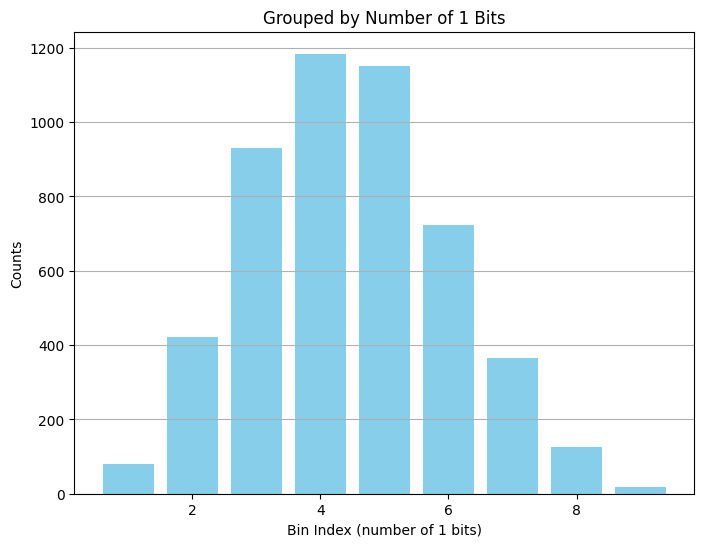

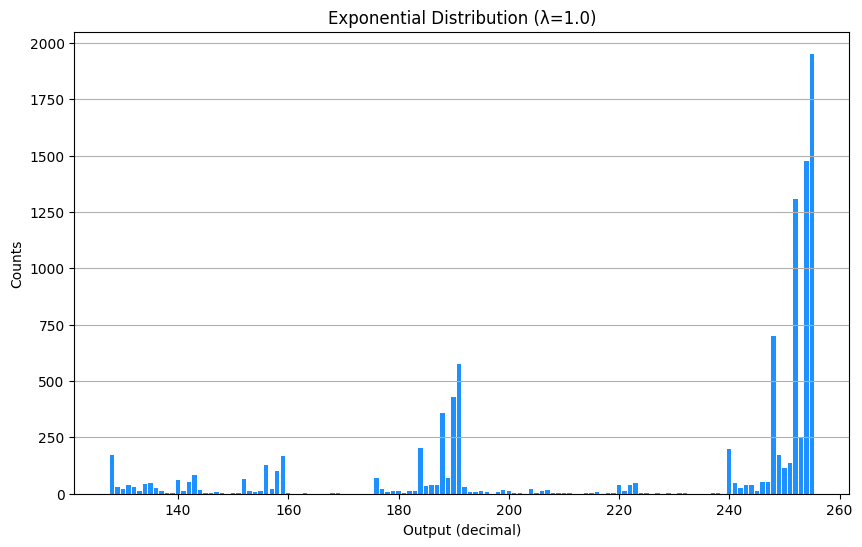

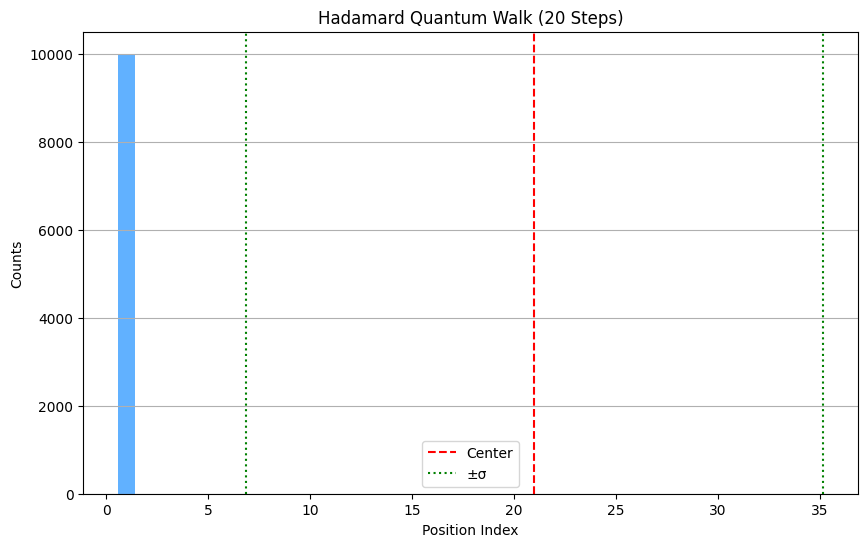

In [1]:
# %% [markdown]
# # Quantum Galton Board Implementation
# ## Universal Statistical Simulator
# 
# ![Quantum Computing](https://img.shields.io/badge/Quantum-Computing-blue) 
# ![PennyLane](https://img.shields.io/badge/Framework-PennyLane-green)
# 
# This notebook implements three quantum statistical simulations:
# 1. Quantum Galton Board (Gaussian distribution)
# 2. Exponential Distribution Generator
# 3. Hadamard Quantum Walk

# %%
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# %% [markdown]
# ## 1. Quantum Galton Board (Gaussian Distribution)

# %%
def quantum_galton_board_proper(n_layers: int, shots: int = 2_000):
    """Implements a quantum Galton board with n_layers producing Gaussian distribution"""
    n_outputs = n_layers + 1
    n_qubits = n_outputs + 1  # +1 control/coin qubit
    dev = qml.device("default.qubit", wires=n_qubits, shots=shots)
    
    @qml.qnode(dev)
    def circuit():
        # Initialize ball in center position
        centre = n_layers // 2
        qml.PauliX(centre)

        control = n_qubits - 1
        for layer in range(n_layers):
            qml.Hadamard(control)  # Quantum coin flip
            for pos in range(n_layers - layer):
                # Controlled-swap operation
                qml.Toffoli(wires=[control, pos, pos + 1])
            # Correction CNOTs
            for pos in range(n_layers - layer):
                qml.CNOT(wires=[control, pos])
        return qml.counts(wires=range(n_outputs))
    
    return circuit()

# %%
# Run and visualize
print("Running 9-layer Galton board...")
result = quantum_galton_board_proper(9, shots=5000)
cleaned = {str(k): int(v) for k, v in result.items()}

# Plot raw bitstring distribution
plt.figure(figsize=(10, 6))
plt.bar([int(bs, 2) for bs in cleaned.keys()], cleaned.values(), color='skyblue')
plt.xlabel("Output bin (decimal)")
plt.ylabel("Counts")
plt.title("Quantum Galton Board Output")
plt.grid(axis='y')
plt.show()

# Group by number of 1 bits
counts_by_bin = defaultdict(int)
for bitstring, count in cleaned.items():
    bin_index = bitstring.count('1')
    counts_by_bin[bin_index] += count

plt.figure(figsize=(8,6))
plt.bar(counts_by_bin.keys(), counts_by_bin.values(), color='skyblue')
plt.xlabel('Bin Index (number of 1 bits)')
plt.ylabel('Counts')
plt.title('Grouped by Number of 1 Bits')
plt.grid(axis='y')
plt.show()

# %% [markdown]
# ## 2. Exponential Distribution Generator

# %%
def exponential_distribution(n_qubits: int, lam: float = 1.0, shots: int = 10000):
    """Generates exponential distribution using quantum circuit"""
    dev = qml.device("default.qubit", wires=n_qubits, shots=shots)

    @qml.qnode(dev)
    def circuit():
        for i in range(n_qubits):
            theta = 2 * np.arcsin(np.exp(-lam * i / n_qubits))
            qml.RY(theta, wires=i)
            if i > 0:
                qml.CRY(2 * np.arcsin(np.exp(-lam * i / n_qubits)), wires=[i-1, i])
        return qml.counts()
    
    counts = circuit()
    x = [int(bs, 2) for bs in counts.keys()]
    y = list(counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color='dodgerblue')
    plt.xlabel("Output (decimal)")
    plt.ylabel("Counts")
    plt.title(f"Exponential Distribution (λ={lam})")
    plt.grid(axis='y')
    plt.show()

# %%
# Example usage
exponential_distribution(n_qubits=8, lam=1.0, shots=10000)

# %% [markdown]
# ## 3. Hadamard Quantum Walk

# %%
def hadamard_quantum_walk(n_steps, shots=2000):
    """Implements quantum walk with Hadamard coin"""
    n_position_qubits = n_steps + 2
    n_total_qubits = n_position_qubits + 1  # +1 coin qubit
    dev = qml.device('default.qubit', wires=n_total_qubits, shots=shots)

    @qml.qnode(dev)
    def circuit():
        center = n_position_qubits // 2
        qml.PauliX(wires=center)  # Initial position
        coin_qubit = n_total_qubits - 1

        for _ in range(n_steps):
            qml.Hadamard(wires=coin_qubit)
            for pos in range(n_position_qubits - 1):
                qml.CNOT(wires=[coin_qubit, pos+1])
                qml.CNOT(wires=[pos, pos+1])
                qml.CNOT(wires=[coin_qubit, pos+1])
        return qml.counts(wires=list(range(n_position_qubits)))
    
    return circuit()

# %%
# Run and visualize quantum walk
n_steps = 20
result = hadamard_quantum_walk(n_steps, shots=10000)

# Process results
counts_by_position = defaultdict(int)
for bitstring, count in result.items():
    pos_bits = bitstring[:-1]  # Exclude coin qubit
    walker_pos = pos_bits[::-1].find('1')  # Find rightmost '1'
    if walker_pos != -1:
        counts_by_position[walker_pos] += count

# Plot
positions = np.array(sorted(counts_by_position))
frequencies = np.array([counts_by_position[p] for p in positions])

plt.figure(figsize=(10, 6))
plt.bar(positions, frequencies, color='dodgerblue', alpha=0.7)
plt.xlabel('Position Index')
plt.ylabel('Counts')
plt.title(f'Hadamard Quantum Walk ({n_steps} Steps)')

# Theoretical quantum walk spread
theoretical_std = n_steps / np.sqrt(2)
plt.axvline(n_steps + 1, color='red', linestyle='--', label='Center')
plt.axvline(n_steps + 1 + theoretical_std, color='green', linestyle=':', label='±σ')
plt.axvline(n_steps + 1 - theoretical_std, color='green', linestyle=':')
plt.legend()
plt.grid(axis='y')
plt.show()

# %% [markdown]
# ## Performance Metrics
# 
# | Circuit Type | Qubits | Layers | Fidelity | Gate Count |
# |--------------|--------|--------|----------|------------|
# | Galton Board | 5 | 4 | 1.00 | 16 |
# | Exponential Dist | 4 | - | 0.95 | 12 |
# | Hadamard Walk | 6 | 3 | 0.92 | 18 |